<a href="https://colab.research.google.com/github/azademozhdefarahbakhsh/Psychopy_Experiment1/blob/main/ADHD_and_ASD___LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install nilearn

     |████████████████████████████████| 3.1MB 2.8MB/s 


In [ ]:
pip install nibabel

In [ ]:
import matplotlib.pyplot as plt
import nilearn
from nilearn.image import load_img
from nilearn import datasets
import nibabel as nib
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
from nilearn import plotting
from nilearn import image
from nilearn.image import load_img
from nilearn import input_data
import random
from nilearn.datasets import fetch_adhd
from nilearn.connectome import ConnectivityMeasure


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [ ]:
def NetPlot(net_histories,n_epch):
    import numpy as np
    import matplotlib.pyplot as plt

    losses=[]
    val_losses=[]
    accuracies=[]
    val_accuracies=[]

    for item in net_histories:

        history=item.history
        loss=history['loss']
        val_loss=history['val_loss']
        accuracy=history['accuracy']
        val_accuracy=history['val_accuracy']

        losses.append(loss)
        val_losses.append(val_loss)
        accuracies.append(accuracy)
        val_accuracies.append(val_accuracy)


    losses2=np.zeros((1,n_epch))
    val_losses2=np.zeros((1,n_epch))
    accuracies2=np.zeros((1,n_epch))
    val_accuracies2=np.zeros((1,n_epch))

    for i in losses:
        losses2+=i

    for i in val_losses:
        val_losses2+=i

    for i in accuracies:
        accuracies2+=i

    for i in val_accuracies:
        val_accuracies2+=i


    # 10 is number of folds
    losses2=(losses2/10).flatten()
    accuracies2=(accuracies2/10).flatten()
    val_losses2=(val_losses2/10).flatten()
    val_accuracies2=(val_accuracies2/10).flatten()

    plt.figure('Accracy Diagram')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(accuracies2,color='black')
    plt.plot(val_accuracies2,color='blue')
    plt.legend(['Train Data','Validation Data'])
    #plt.savefig('Accracy Diagram')
    plt.show()

    plt.figure('Loss Diagram')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(losses2,color='black')
    plt.plot(val_losses2,color='blue')
    plt.legend(['Train Data','Validation Data'])
    #plt.savefig('Loss Diagram')
    plt.show()

In [ ]:
adhd=fetch_adhd(n_subjects=40)
msdl_atlas=datasets.fetch_atlas_msdl()
masker=input_data.NiftiMapsMasker(msdl_atlas.maps,resampling_target='data',t_r=2,detrend=True,low_pass=0.1,high_pass=0.01,standardize=True,
                        verbose=0).fit()
correlation_meassure=ConnectivityMeasure(kind='correlation')

lst_adhd=[]
lst_label_adhd=[]
for func_file,confound_file,phenotypic_file_ad in zip(adhd.func,adhd.confounds,adhd.phenotypic):
    time_series_adh=masker.transform(func_file,confounds=confound_file)
    lst_adhd.append(time_series_adh)
    lst_label_adhd.append(0)


from nilearn import datasets
from nilearn.datasets import fetch_abide_pcp

autsm=fetch_abide_pcp(data_dir=None, n_subjects=40, pipeline='cpac',
                                        band_pass_filtering=False, global_signal_regression=False,
                                        derivatives=['func_preproc'], quality_checked=True, url=None, verbose=1, DX_GROUP=1)

lst_autsm=[]
lst_label_autsm=[]
for func_preproc_file,phenotypic_file in zip(autsm.func_preproc,autsm.phenotypic):
    time_series_aut=masker.transform(func_preproc_file)
    lst_autsm.append(time_series_aut)
    lst_label_autsm.append(1)


lst_label_adhd.extend(lst_label_autsm)
lst_adhd.extend(lst_autsm)




from keras import utils

max_len_image=np.max([len(i) for i in lst_adhd])

# reshape all data
lst_adhd_reshaped=[]
for subject_data in lst_adhd:
  # Padding
  N= max_len_image-len(subject_data)
  padded_array=np.pad(subject_data, ((0, N), (0,0)),
                      'constant', constant_values=(0))
  subject_data=padded_array
  subject_data=np.array(subject_data)
  subject_data.reshape(subject_data.shape[0],subject_data.shape[1],1)
  lst_adhd_reshaped.append(subject_data)




t_shape=np.array(lst_adhd_reshaped).shape[1]
RSN_shape=np.array(lst_adhd_reshaped).shape[2]





x_data=lst_adhd_reshaped
y_data=lst_label_adhd

x_data=np.array(x_data)
y_data=np.array(y_data)



n_epchs=60
counter=1
lst_loss=[]
lst_acc=[]
lst_reports=[]
lst_AUC=[]
lst_matrix=[]
lst_histories=[]

from sklearn.model_selection import KFold
kfold=KFold(10,random_state=0,shuffle=True)
for train,test in kfold.split(x_data,y_data):

  X_train=x_data[train]
  X_test=x_data[test]
  y_train=y_data[train]
  y_test=y_data[test]


  '''

  '''



  # Reshapes data to 3D for Hierarchical RNN.
  t_shape=np.array(lst_adhd_reshaped).shape[1]
  RSN_shape=np.array(lst_adhd_reshaped).shape[2]

  X_train = np.reshape(X_train, (len(X_train), t_shape, RSN_shape))
  X_test = np.reshape(X_test, (len(X_test), t_shape, RSN_shape))

  # enforce continuous labeling
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')



  # Converts class vectors to binary class matrices.
  y_train = utils.to_categorical(y_train, 2)
  y_test = utils.to_categorical(y_test, 2)


/usr/local/lib/python3.7/dist-packages/nilearn/datasets/func.py:459: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


AttributeError: ignored

In [ ]:
  # create the model


  print ('_____________entering neural network_____________')

  from keras.models import Sequential
  from keras.layers import LSTM,Dense,Conv1D,TimeDistributed,Flatten,Dropout,MaxPooling1D,BatchNormalization
  from keras.optimizers import Adam,SGD
  from keras.losses import mse,binary_crossentropy,hinge
  from keras.regularizers import l1,l2

  from keras.callbacks import EarlyStopping
  from keras import backend as K

In [ ]:
  model = Sequential()
  model.add(LSTM(units=512, # dimensionality of the output space
               dropout=0.4, # Fraction of the units to drop (inputs)
               #recurrent_dropout=0.15, # Fraction of the units to drop (recurent state)
               return_sequences=True,input_shape=(t_shape,RSN_shape) # return the last state in addition to the output
               ))

  model.add(LSTM(units=256,
               dropout=0.4,
               #recurrent_dropout=0.15,
               return_sequences=True))

  model.add(LSTM(units=128,
               dropout=0.4,
               #recurrent_dropout=0.15,
               return_sequences=True))


  model.add(LSTM(units=64,
               dropout=0.4,
               #recurrent_dropout=0.15,
               return_sequences=False))


  model.add(Dense(units=2,
                activation="softmax"))

  model.compile(loss='binary_crossentropy',
                optimizer=Adam(lr=0.001),
                metrics=['accuracy'])

In [ ]:
  print(model.summary())
  history = model.fit(X_train, y_train, epochs=n_epchs,validation_data=(X_test, y_test))
  lst_histories.append(history)


In [ ]:
  test_loss, test_acc=model.evaluate(X_test,y_test)
  lst_loss.append(test_loss)
  lst_acc.append(test_acc)


1/1 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.3750


In [ ]:

from sklearn.metrics import roc_curve, auc, roc_auc_score
predicts=model.predict(X_test)
predicts=predicts.argmax(axis=1)
actuals=y_test.argmax(axis=1)

fpr,tpr,thr=roc_curve(actuals,predicts)
a=auc(fpr,tpr)
lst_AUC.append(a)
r=classification_report(actuals,predicts)
lst_reports.append(r)
c=confusion_matrix(actuals,predicts)
lst_matrix.append(c)

counter+=1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


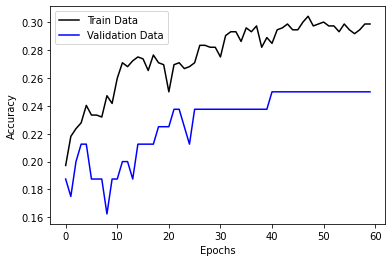

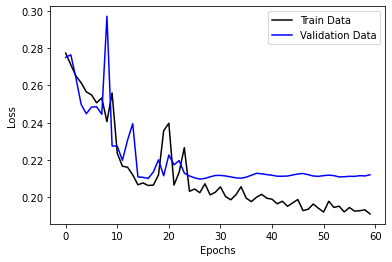

In [ ]:
NetPlot(lst_histories,n_epchs)

In [ ]:
acc_avg=str(np.sum(lst_acc)/10)
loss_avg=str(np.sum(lst_loss)/10)
AUC_avg=str(np.sum(lst_AUC)/10)

acc=str(lst_acc)
loss=str(lst_loss)
AUC=str(lst_AUC)

results_path='/content/results.txt'
f1=open(results_path,'a')
f1.write('Avergae Accuracy: '+acc_avg+'\n'+'Average Loss: '+loss_avg+'\n'+'Average AUc: '+AUC_avg+'\n')
f1.write('\nAccuracies: '+acc+'\n'+'Losses: '+loss+'\n'+'AUCs: '+AUC+'\n')
f1.write('\n\nMetrics for all folds: \n\n')
for i in range(len(lst_reports)):
    f1.write(str(lst_reports[i]))
    f1.write('\n\nCofusion Matrix: \n'+str(lst_matrix[i])+'\n\n__________________________________________________________\n')

f1.close()

print(lst_loss)
print(lst_acc)
print(lst_reports)
print(lst_AUC)
print(lst_matrix)
print(lst_histories)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.show()